# Prediction Intervals

> In this example we'll see how to produce prediction intervals.

::: {.callout-warning collapse="true"}

## Prerequesites

This tutorial assumes basic familiarity with StatsForecast. For a minimal example visit the [Quick Start](https://nixtla.github.io/statsforecast/examples/getting_started_short.html) 
:::

## Introduction 




If we only produce point forecasts, there is no way to tell how much uncertainty there is around our forecasts. A **prediction interval** gives us a measurement of this uncertainty with some prespecified probability o confidence level. In this notebook, we'll see how  [StatsForecast](https://nixtla.github.io/statsforecast/) allows us to easily generate prediction intervals for multiple forecasting models. 

::: {.callout-important}
## Important 
Although the terms are often confused, prediction intervals are not the same as [confidence intervals](https://robjhyndman.com/hyndsight/intervals/). 
:::

**Outline:**

1. Install libraries 
2. Load and explore the data
3. Prepare dataset for StatsForecast modeling 
4. Train the models 
5. Plot prediction intervals 

::: {.callout-tip}
You can use Colab to run this Notebook interactively <a href="https://colab.research.google.com/github/Nixtla/statsforecast/blob/main/nbs/examples/CrossValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
::: 

## Install libraries 

We assume that you have StatsForecast already installed. If not, check this guide for instructions on [how to install StatsForecast](https://nixtla.github.io/statsforecast/examples/installation.html) 

Install the necessary packages using `pip install statsforecast`

In [ ]:
pip install statsforecast

In [ ]:
import random
import warnings
warnings.filterwarnings("ignore")
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, Naive, SeasonalNaive, RandomWalkWithDrift, HistoricAverage

## Load and explore the data

For this example, we'll use the Hourly dataset from the [M4 Competition](https://www.sciencedirect.com/science/article/pii/S0169207019301128) 

In [ ]:
%%capture
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv
!wget https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv

In [ ]:
train = pd.read_csv('M4-Hourly.csv')
test = pd.read_csv('M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

Since the goal of this notebook is to show how to generate prediction intervals, we'll use only a subset of the data to reduce the total computational time. 

In [ ]:
n_series = 8
uids = train['unique_id'].unique()[:n_series]
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

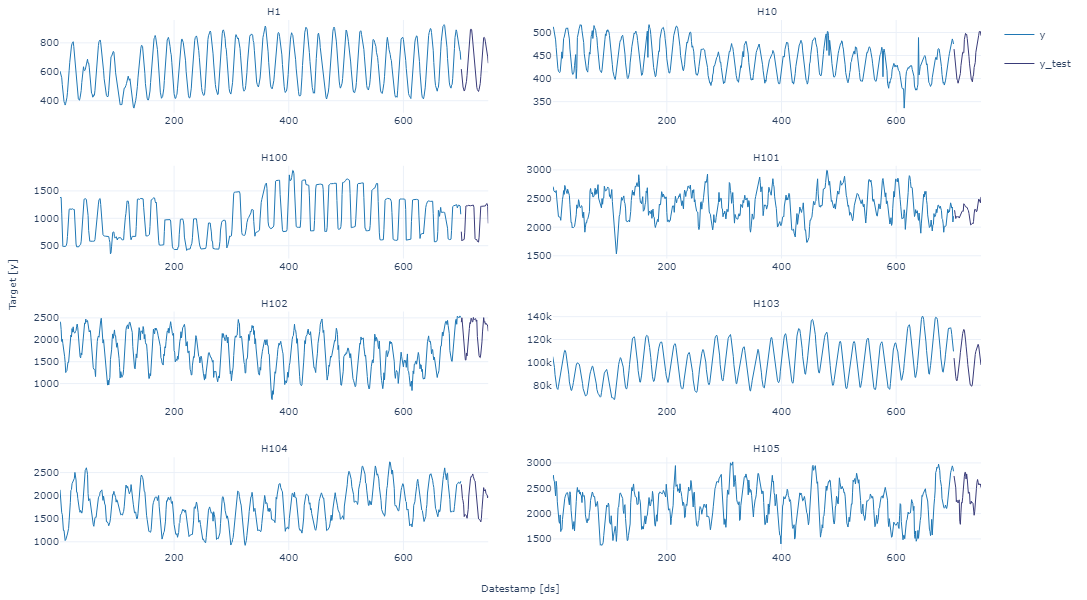

In [ ]:
StatsForecast.plot(train, test, plot_random=False)

## Prepare dataset for `StatsForecast` modelling

In this particular case, the data already has the format requiered by `StatsForecast`

In [ ]:
train.head()

unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0

As a reminder, the input to StatsForecast is always a data frame in [long format](https://www.theanalysisfactor.com/wide-and-long-data/) with three columns: `unique_id`, `ds`, and `y`. 

* The `unique_id` (string, int, or category) column is a unique identifier for the series. 
* The `ds` (int or datestamp) column is either an integer indexing time or a datestamp in format YYYY-MM-DD or YYYY-MM-DD HH:MM:SS. 
* The `y` (numeric) column is the measurement we want to forecast, in this case, the number of trips. 

## Train models

To train multiple models with their respective prediction intervals using `StatsForecast`, we'll need to: 

1. Create a list of models we want to use. 
2. Fit the models by instantiating a new `StatsForecast`object. 
3. Select the confidence levels associated to the prediction intervals. 
4. Generate the forecasts.

In [ ]:
models = [
    AutoARIMA(season_length=24, approximation=True),
    Naive(),
    SeasonalNaive(season_length=24),
    RandomWalkWithDrift(),
    HistoricAverage()
]

::: {.callout-tip}
## Tip 

For this example, we selected [AutoARIMA](https://nixtla.github.io/statsforecast/models.html#autoarima) and several baseline models: 

* [Naive](https://nixtla.github.io/statsforecast/models.html#naive)
* [SeasonalNaive](https://nixtla.github.io/statsforecast/models.html#seasonalnaive)
* [RandomWalkWithDrift](https://nixtla.github.io/statsforecast/models.html#randomwalkwithdrift)
* [HistoricAverage](https://nixtla.github.io/statsforecast/models.html#historicaverage).  

:::

In [ ]:
fcst = StatsForecast(df=train, 
                     models=models, 
                     freq='H', 
                     n_jobs=-1)

In [ ]:
levels = [80, 90, 95, 99] # for the prediction intervals

In [ ]:
forecasts = fcst.forecast(h=48, level=levels)
forecasts = forecasts.reset_index()
forecasts.head()

unique_id   ds   AutoARIMA  AutoARIMA-lo-99  AutoARIMA-lo-95  \
0        H1  701  616.084167       585.106445       592.513000   
1        H1  702  544.432129       494.394348       506.358063   
2        H1  703  510.414490       443.625366       459.594238   
3        H1  704  481.046539       404.228729       422.595398   
4        H1  705  460.893066       378.863678       398.476410   

   AutoARIMA-lo-90  AutoARIMA-lo-80  AutoARIMA-hi-80  AutoARIMA-hi-90  \
0       596.302612       600.671814       631.496460       635.865662   
1       512.479370       519.536865       569.327393       576.384888   
2       467.764801       477.184906       543.644043       553.064148   
3       431.992798       442.827393       519.265686       530.100281   
4       408.511383       420.081024       501.705109       513.274780   

   AutoARIMA-hi-95  ...   RWD-hi-99  HistoricAverage  HistoricAverage-lo-80  \
0       639.655273  ...  789.416626       638.488586             436.697418   
1       582.506165  ...  833.254150       638.488586             436.697418   
2       561.234741  ...  866.990601       638.488586             436.697418   
3       539.497681  ...  895.510132       638.488586             436.697418   
4       523.309692  ...  920.702881       638.488586             436.697418   

   HistoricAverage-lo-90  HistoricAverage-lo-95  HistoricAverage-lo-99  \
0             379.492432             329.875641              232.90242   
1             379.492432             329.875641              232.90242   
2             379.492432             329.875641              232.90242   
3             379.492432             329.875641              232.90242   
4             379.492432             329.875641              232.90242   

   HistoricAverage-hi-80  HistoricAverage-hi-90  HistoricAverage-hi-95  \
0             840.279724             897.484741             947.101562   
1             840.279724             897.484741             947.101562   
2             840.279724             897.484741             947.101562   
3             840.279724             897.484741             947.101562   
4             840.279724             897.484741             947.101562   

   HistoricAverage-hi-99  
0            1044.074707  
1            1044.074707  
2            1044.074707  
3            1044.074707  
4            1044.074707  

[5 rows x 47 columns]

Once the forecasts are ready, we'll merge them with the actual values. In the next section, we'll use this dataframe to visualize the forecasts and their respective prediction intervals. 

In [ ]:
test = test.merge(forecasts, how='left', on=['unique_id', 'ds'])

## Plot prediction intervals

We'll plot each baseline model separately to better visualize their prediction intervals. 

### AutoARIMA

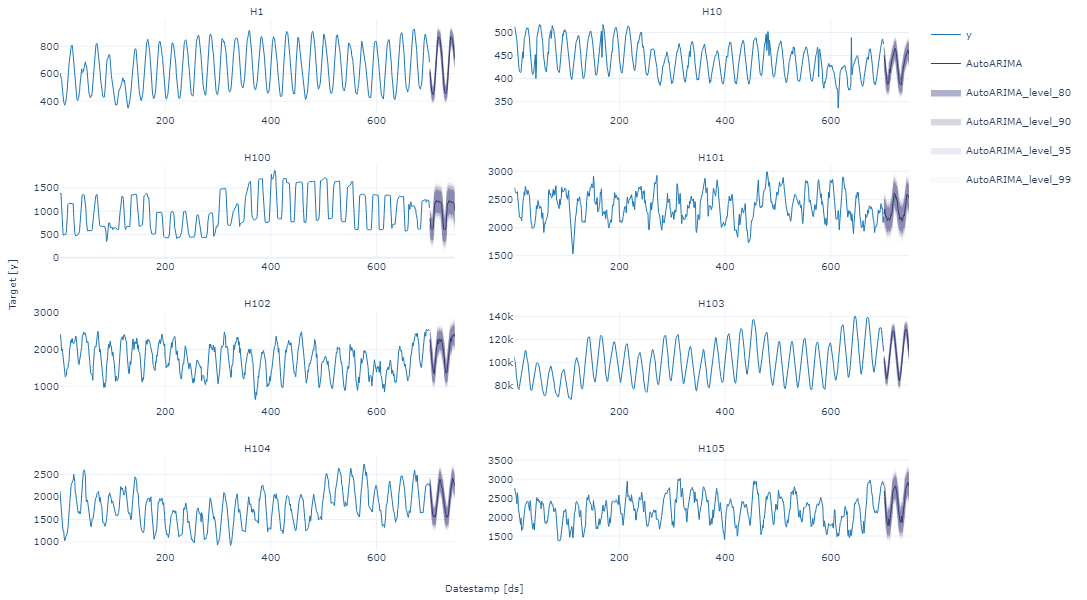

In [ ]:
StatsForecast.plot(train, test, level=levels, models=['AutoARIMA'], plot_random=False)

### Naive 

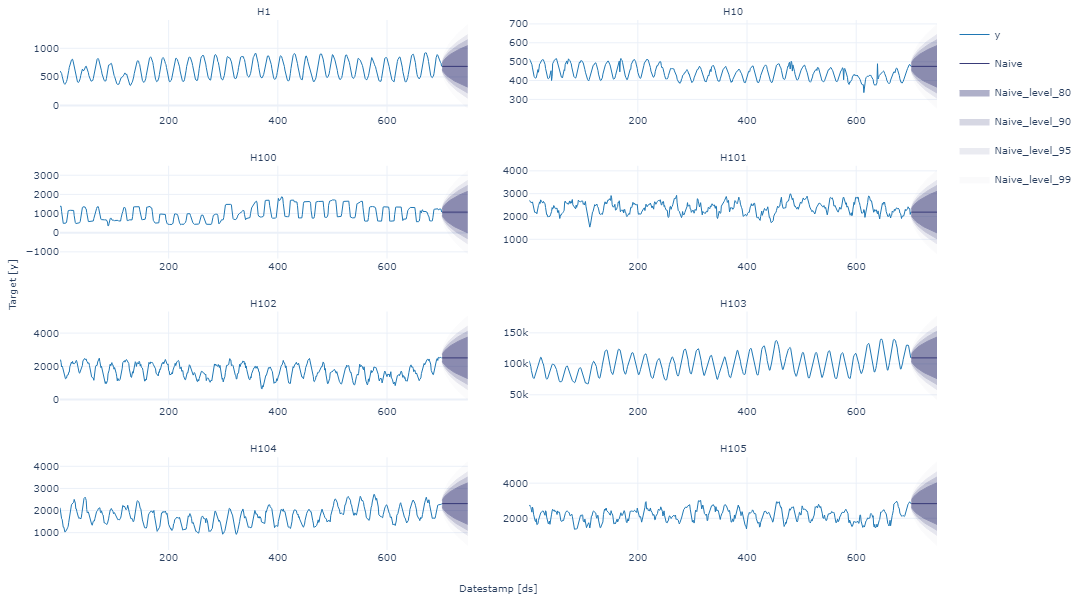

In [ ]:
StatsForecast.plot(train, test, level=levels, models=['Naive'], plot_random=False)

### Seasonal Naive

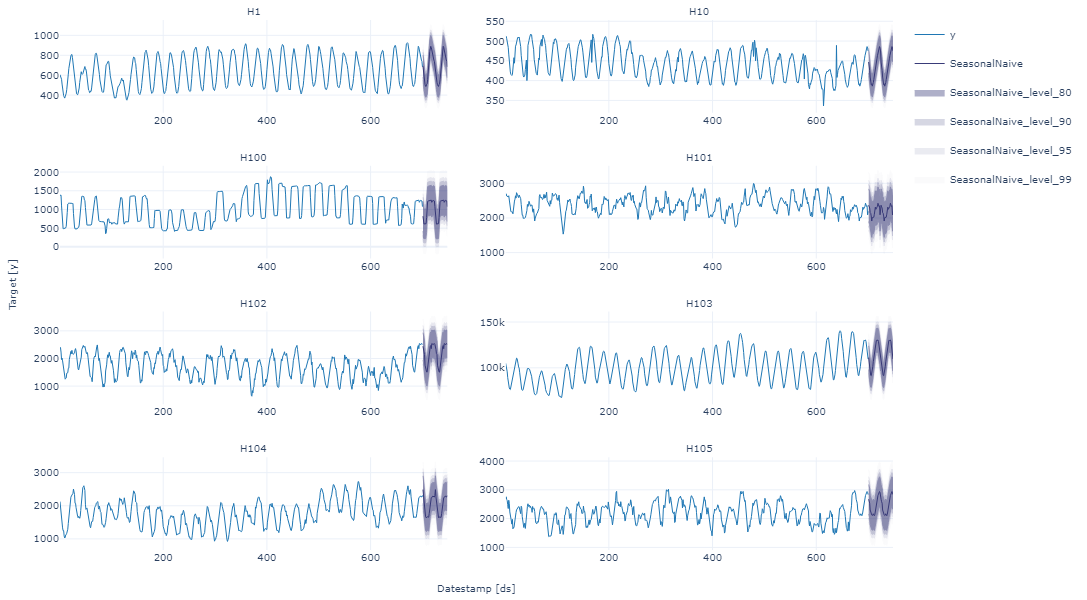

In [ ]:
StatsForecast.plot(train, test, level=levels, models=['SeasonalNaive'], plot_random=False)

### Random Walk with Drift

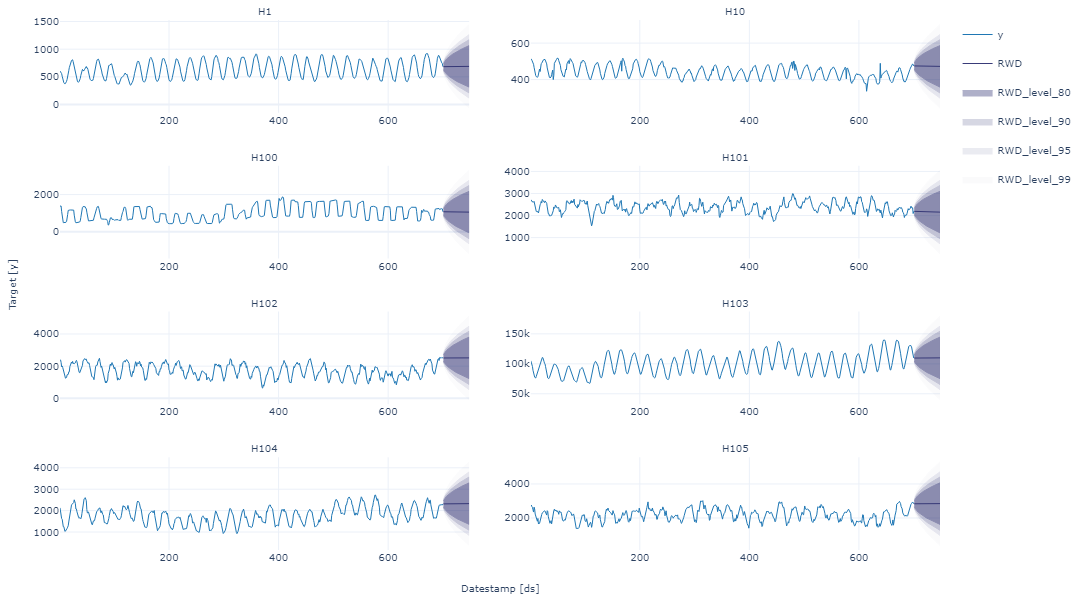

In [ ]:
StatsForecast.plot(train, test, level=levels, models=['RWD'], plot_random=False)

### Historic Average

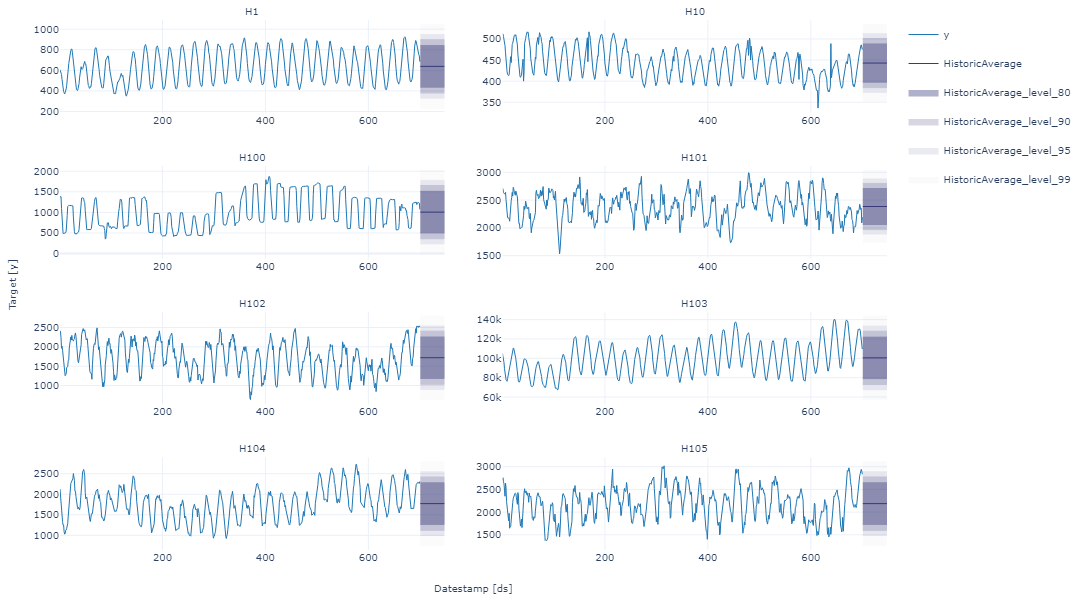

In [ ]:
StatsForecast.plot(train, test, level=levels, models=['HistoricAverage'], plot_random=False)

From these plots, we can conclude that the uncertainty around each forecast varies according to the method that is being used. For the same time series, one method can predict a wider range of possible future values than others. 

## References 

[Rob J. Hyndman and George Athanasopoulos (2018). "Forecasting principles and practice, The Statistical Forecasting Perspective"](https://otexts.com/fpp3/perspective.html).